In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        """
        A simple CNN from scratch with 32x32 input images
        
        Args:
            num_classes: Number of output classes (default: 10)
        """
        super(SimpleCNN, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32x32 -> 32x32
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 16x16 -> 16x16
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 8x8 -> 8x8
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Fully Connected
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize the model
model = SimpleCNN(num_classes=10).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout): Dr

In [ ]:
# # Create folder structure for images
# data_dir = Path('data')
# train_dir = data_dir / 'train'
# test_dir = data_dir / 'test'

# # Create directories for each class (modify class names as needed)
# classes = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 
#            'class_5', 'class_6', 'class_7', 'class_8', 'class_9']

# # Create train and test folders with subfolders for each class
# for class_name in classes:
#     (train_dir / class_name).mkdir(parents=True, exist_ok=True)
#     (test_dir / class_name).mkdir(parents=True, exist_ok=True)

# print("Folder structure created:")
# print(f"✓ Training data: {train_dir.absolute()}")
# print(f"✓ Test data: {test_dir.absolute()}")
# print(f"\nClasses created: {', '.join(classes)}")
# print("\nPlace your 32x32 images in the corresponding class folders.")

Folder structure created:
✓ Training data: d:\Users\Public\AIM\Year 3 Sem 2\ML\CNN Activity 1\data\train
✓ Test data: d:\Users\Public\AIM\Year 3 Sem 2\ML\CNN Activity 1\data\test

Classes created: class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8, class_9

Place your 32x32 images in the corresponding class folders.


In [3]:
train_dir = 'LT01_digits'
test_dir = 'LT10_digits'

In [ ]:
# Data loading setup
def get_data_loaders(batch_size=32, num_workers=0):
    """
    Load training, validation and test data with appropriate transformations.
    Splits training data into 70% train and 30% validation.
    
    Args:
        batch_size: Batch size for DataLoader
        num_workers: Number of workers for DataLoader
        
    Returns:
        train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset
    """
    # Define transforms for 32x32 images
    transform_train = transforms.Compose([
        transforms.Resize((32, 32)),  # Ensure 32x32
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    transform_val = transforms.Compose([
        transforms.Resize((32, 32)),  # Ensure 32x32
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize((32, 32)),  # Ensure 32x32
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Load full training dataset
    full_train_dataset = ImageFolder(train_dir, transform=transform_train)
    
    # Split into 70% train and 30% validation
    train_size = int(0.7 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_train_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Apply validation transform to validation dataset
    val_dataset.dataset.transform = transform_val
    
    # Load test dataset
    test_dataset = ImageFolder(test_dir, transform=transform_test)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

# Function to train the model
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Function to test/validate the model
def test_model(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

print("✓ Data loading functions defined")

✓ Data loading functions defined


Training set size: 100
Test set size: 100
Number of classes: 10
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Epoch [5/20]
  Train Loss: 1.6101, Train Acc: 48.00%
  Test Loss: 2.6354, Test Acc: 14.00%
Epoch [10/20]
  Train Loss: 0.9019, Train Acc: 71.00%
  Test Loss: 2.4212, Test Acc: 30.00%
Epoch [15/20]
  Train Loss: 0.2016, Train Acc: 90.00%
  Test Loss: 2.6103, Test Acc: 35.00%
Epoch [20/20]
  Train Loss: 0.2711, Train Acc: 97.00%
  Test Loss: 2.3127, Test Acc: 39.00%


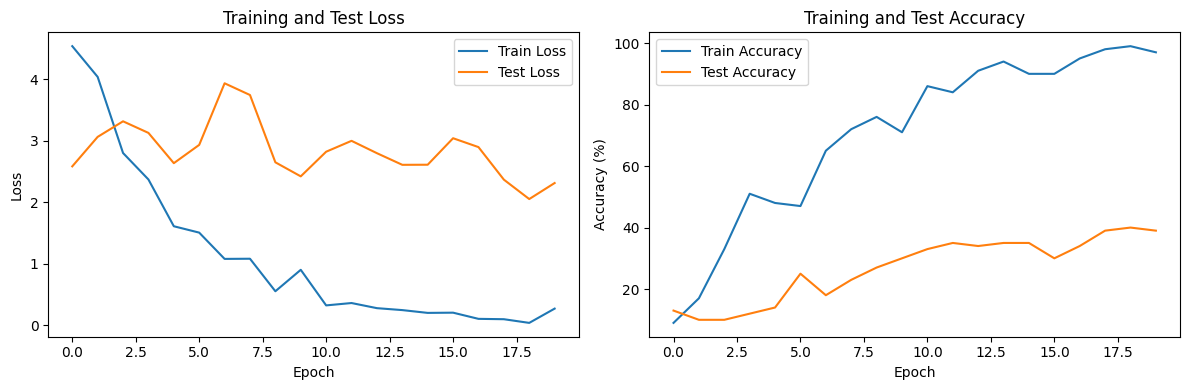

Model saved as cnn_model.pth
✓ Training template ready (uncomment to use)


In [ ]:
# Training template (uncomment and modify as needed)

# Initialize training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
batch_size = 32

# Load data
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_data_loaders(batch_size=batch_size)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.dataset.classes)}")
print(f"Classes: {train_dataset.dataset.classes}")

# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = test_model(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Evaluate on test set
test_loss, test_acc = test_model(model, test_loader, criterion, device)
print(f'\nFinal Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')

ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
plt.tight_layout()
plt.show()

# Save model
torch.save(model.state_dict(), 'cnn_model.pth')
print('Model saved as cnn_model.pth')


print("✓ Training template ready (uncomment to use)")